In [158]:
import numpy as np
import cv2
from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, Concatenate
from keras.models import Model
import keras
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import load_img,img_to_array
from keras.optimizers import Adam,SGD
from numpy import genfromtxt
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt
from keras import regularizers

In [29]:
def create_model():
    input_im = Input(shape=(128,128,3))

    conv1 = Conv2D(96, kernel_size=7, activation='relu')(input_im)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(256, kernel_size=5, activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1 = Dropout(0.25)(pool2)


    conv3 = Conv2D(384, kernel_size=3, activation='relu')(drop1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop2 = Dropout(0.25)(pool3)
  
    
    dense1 = Dense(1024, activation='relu')(drop2)    
   
    flat1 = Flatten()(dense1)
        
    gen = Dense(2, activation='softmax')(flat1)    
    age = Dense(8, activation='softmax')(flat1)

    model = Model(inputs=input_im, outputs=[gen,age]) 

    return model   
model=create_model()

model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])


In [264]:
# Read CSV annotations
train_anns = genfromtxt('anns/'+'train_anns.csv', delimiter=',',dtype=str)
val_anns = genfromtxt('anns/'+'val_anns.csv', delimiter=',',dtype=str)
np.random.shuffle(train_anns)
np.random.shuffle(val_anns)

# usage : custom_gen(range(0,3000+1))
def custom_gen(_anns,use_range,batch_size):
    while True:
        image_data = []
        label_data_gender = []
        label_data_age = []
        start_indx = np.random.randint(low=use_range[0],high=use_range[-batch_size])
        
        # Read anns
        batch_row = _anns[start_indx:start_indx+batch_size]       
                    
        
        # Read images
        for row in batch_row:
            im = load_img('images/'+row[0]+'/'+row[2]+'.'+row[1],target_size=(128, 128,3))  #PIL Image          
            im = img_to_array(im) # Numpy
            im = im/255.
            image_data.append(im)               
            
            label_data_gender.append(np.fromstring(row[5], sep=' ')) # target gender
            label_data_age.append(np.fromstring(row[6], sep=' ')) # target gender
            
   
        image_data = np.array(image_data)
 
        
        yield( image_data, [label_data_gender,label_data_age] )       
        

In [265]:
train_range = range(0,10000+1) # all = 10000
val_range = range(0,1333+1) # all = 1333

print('train_range : ',train_range[0],'-',train_range[-1],\
      '\nval_range',val_range[0],'-',val_range[-1])
batch_size = 16

train_range :  0 - 10000 
val_range 0 - 1333


# TRAIN

In [266]:

history = model.fit_generator(
        custom_gen(train_anns,train_range,batch_size), 
        steps_per_epoch=max(1, len(train_range)//batch_size),
        epochs=10,        
        validation_data=custom_gen(val_anns,val_range,batch_size),
        validation_steps=max(1, len(val_range)//batch_size),)

Epoch 1/10
625/625 [==============================] - 229s 367ms/step - loss: 1.5445 - dense_5_loss: 0.3967 - dense_6_loss: 1.1478 - dense_5_acc: 0.8180 - dense_6_acc: 0.5834 - val_loss: 1.8581 - val_dense_5_loss: 0.4305 - val_dense_6_loss: 1.4275 - val_dense_5_acc: 0.8185 - val_dense_6_acc: 0.5038
Epoch 2/10
625/625 [==============================] - 87s 139ms/step - loss: 1.2633 - dense_5_loss: 0.3312 - dense_6_loss: 0.9320 - dense_5_acc: 0.8545 - dense_6_acc: 0.6782 - val_loss: 1.7753 - val_dense_5_loss: 0.4241 - val_dense_6_loss: 1.3512 - val_dense_5_acc: 0.8185 - val_dense_6_acc: 0.5316
Epoch 3/10
625/625 [==============================] - 76s 121ms/step - loss: 0.9997 - dense_5_loss: 0.2803 - dense_6_loss: 0.7194 - dense_5_acc: 0.8834 - dense_6_acc: 0.7528 - val_loss: 1.8897 - val_dense_5_loss: 0.4226 - val_dense_6_loss: 1.4671 - val_dense_5_acc: 0.8193 - val_dense_6_acc: 0.5429
Epoch 4/10
625/625 [==============================] - 76s 121ms/step - loss: 0.7999 - dense_5_loss: 0.

# TEST

True 	 m 		| m 0.8908742
False 	 (4-6) 	| (25-32) 0.4491531


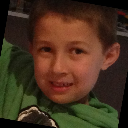

In [300]:
gender_dict = ['m','f']
age_dict = ['(0-2)','(4-6)','(8-12)','(15-20)','(25-32)','(38-43)','(48-53)','(60-100)']



rand_indx = np.random.randint(low=0,high=1333)
rowp = val_anns[rand_indx]
im_ori = load_img('images/'+rowp[0]+'/'+rowp[2]+'.'+rowp[1],target_size=(128, 128,3))

im = img_to_array(im_ori)
im = im/255.
im = np.expand_dims(im, axis=0)

genderp,agep = model.predict(im ,verbose = 0)

print(rowp[4]==gender_dict[genderp.argmax()],'\t',rowp[4],'\t\t|',gender_dict[genderp.argmax()],np.amax(genderp))
print(rowp[3]==age_dict[agep.argmax()],'\t',rowp[3],'\t|',age_dict[agep.argmax()],np.amax(agep))

display(im_ori)

True

In [ ]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
reset_weights(model)

In [ ]:
print (model.get_weights())

In [301]:
model.save('my_model.h5')